## Decision Tree - mit Validierungsmenge

- Aufteilen in Trainings-, Validierungs- und Testmengen
- Unser Datensatz hat über 15.000 Einträge, daher macht es Sinn, die Daten in Trainings-, Validierungs- und Testmengen aufzuteilen.
- Wir teilen die Daten wie folgt auf: 60% für das Training, 20% für die Validierung und 20% für den Test.

#### Vorgehen udn Erklärungen: siehe Notebook v3 (Verlinkung)

In [20]:
import pandas as pd
import geopandas as gpd

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_val_predict, learning_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# GeoJSON-Datei laden
gdf = gpd.read_file('../../../data/processed_data/simra_osm_all.geojson')

In [5]:
df = gdf.drop(columns=['markers', 'id', 'index_right', 'geometry', 'highway', 'incidents', 'rides', 'type'])
df.head(2)

,score,maxspeed,asphalt,concrete,paving_stone,sett,unpaved,cycleway,footway,highway_rare,living_street,path,primary,residential,secondary,service,tertiary,track
0,0.0,50,0.0,1.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0
1,0.0,30,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.0


In [6]:
# Features und Zielvariable trennen
X = df.drop(columns='score')
y = df['score']

### 1. Aufteilen in Trainings-, Validierungs- und Testmengen (60% Training, 20% Validation, 20% Test)

In [7]:
# Daten aufteilen: 80% Training + Validierung, 20% Test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Weiter aufteilen: 80% Training, 20% Validierung
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=1)

In [8]:
print(f"Anzahl der Trainingsdaten: {X_train.shape[0]}")
print(f"Anzahl der Validierungsdaten: {X_val.shape[0]}")
print(f"Anzahl der Testdaten: {X_test.shape[0]}")

Anzahl der Trainingsdaten: 10023
Anzahl der Validierungsdaten: 2506
Anzahl der Testdaten: 3133


### 2. Hyperparameter-Tuning mit GridSearchCV

In [9]:
# DecisionTreeRegressor-Modell erstellen
dt = DecisionTreeRegressor(random_state=1)

In [10]:
# Hyperparameter-Tuning mit GridSearchCV
param_grid = {
    'max_depth': range(1, 21), 
    'min_samples_split': [2, 10, 20], 
    'min_samples_leaf': [1, 5, 10], 
    'max_features': [None, 0.5, 'sqrt', 'log2']
}

In [11]:
# GridSearchCV einrichten (5-fache Cross-Validation auf Trainingsmenge)
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1)

In [12]:
# Modelltraining mit GridSearchCV auf der Trainingsmenge
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': range(1, 21),
                         'max_features': [None, 0.5, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             scoring='r2')

In [13]:
# Beste Parameter und Modell
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Best Score: {grid_search.best_score_}")
print(f"Best Params: {best_params}")

Best Score: 0.006395877497076219
Best Params: {'max_depth': 2, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2}


### Prüfung auf Validierungsdaten

In [14]:
# Prüfung auf Validierungsdaten
y_val_pred = best_model.predict(X_val)

val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_medae = median_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)

print("\nBewertung auf den Validierungsdaten:")
print(f'Mean Squared Error: {val_mse}')
print(f'R²-Score: {val_r2}')
print(f'Mean Absolute Error (MAE): {val_mae}')
print(f'Median Absolute Error: {val_medae}')
print(f'Root Mean Squared Error (RMSE): {val_rmse}')


Bewertung auf den Validierungsdaten:
Mean Squared Error: 0.0007970788714129624
R²-Score: -0.012286551965387416
Mean Absolute Error (MAE): 0.013818480644196503
Median Absolute Error: 0.00707383986264095
Root Mean Squared Error (RMSE): 0.028232585276820866


### Bewertung auf den Testdaten

In [15]:
# Bewertung auf den Testdaten
y_test_pred = best_model.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_medae = median_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

print("\nBewertung auf den Testdaten:")
print(f'Mean Squared Error: {test_mse}')
print(f'R²-Score: {test_r2}')
print(f'Mean Absolute Error (MAE): {test_mae}')
print(f'Median Absolute Error: {test_medae}')
print(f'Root Mean Squared Error (RMSE): {test_rmse}')


Bewertung auf den Testdaten:
Mean Squared Error: 0.002569701038819805
R²-Score: -0.0012462545057903007
Mean Absolute Error (MAE): 0.016157674877448226
Median Absolute Error: 0.00707383986264095
Root Mean Squared Error (RMSE): 0.050692218720626195


### Interpretation Fehlermetriken:

**MSE (Mean Squared Error)**:
  - Validierungsmenge: 0.00079
  - Testmenge: 0.00256
  - Der MSE gibt an, wie weit die vorhergesagten Werte im Durchschnitt von den tatsächlichen Werten abweichen. Kleinere Werte sind besser, aber der Unterschied zwischen den beiden Mengen ist gering.

**RMSE (Root Mean Squared Error)**:
  - Validierungsmenge: 0.0282
  - Testmenge: 0.0506
  - RMSE ist die Quadratwurzel des MSE. Diese Werte zeigen, dass die Fehler in beiden Datensätzen nicht weit auseinander liegen.

**MAE (Mean Absolute Error)**:
  - Validierungsmenge: 0.0138
  - Testmenge: 0.0161
  - Der MAE gibt den durchschnittlichen absoluten Fehler an. Auch hier sind die Werte relativ klein, was gut ist. Allerdings zeigt dies nicht, ob das Modell systematisch schlechte Vorhersagen trifft.

**R² (Bestimmtheitsmaß)**:
  - Validierungsmenge: -0.01228
  - Testmenge: -0.00124
  - Das R²-Maß gibt an, wie gut das Modell die Varianz der Zielvariablen erklärt. Ein negativer Wert bedeutet, dass das Modell schlechter ist als ein einfaches Mittelwertmodell (das heißt, das Modell ist im Grunde unbrauchbar, da es die Daten nicht besser als ein Mittelwert vorhersagt).

**Interpretation**:

- MSE, RMSE, und MAE sind relativ niedrig, was auf geringe Vorhersagefehler hinweist, aber diese Werte müssen in den Kontext der Daten (Größenordnung der Zielwerte) gesetzt werden. &rarr; viele Werte der Zielvariablen = 0
- Der negative R²-Wert ist problematisch. Er deutet darauf hin, dass das Modell auf den Validierungs- und Testmengen schlecht generalisiert und im Grunde nicht viel Varianz in den Daten erklärt. Ein negativer R² bedeutet, dass das Modell schlechter ist als eine einfache Mittelwertvorhersage.

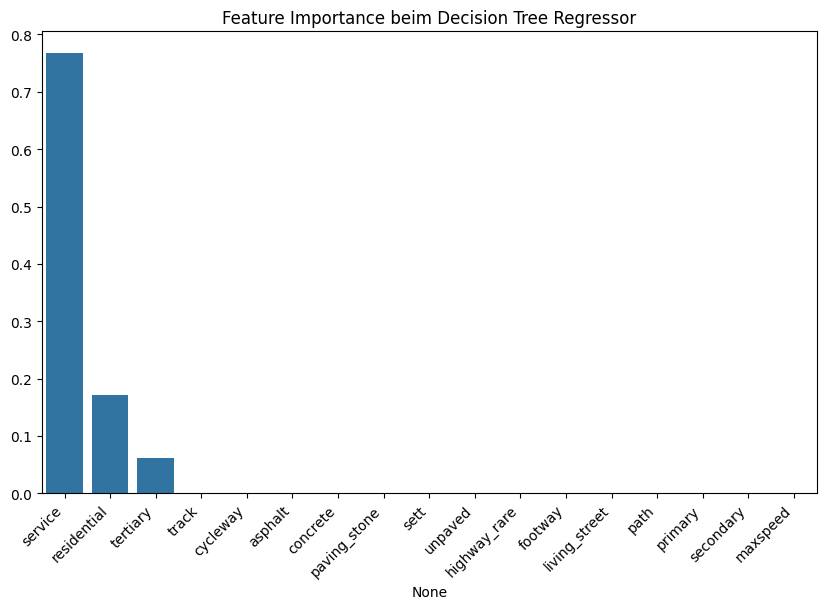

In [16]:
# Feature Importance

feature_importance = best_model.feature_importances_

# Sortieren der Features nach Wichtigkeit
sorted_indices = np.argsort(feature_importance)[::-1]

features = X_train.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=X.columns[sorted_indices], y=feature_importance[sorted_indices])
plt.xticks(rotation=45, ha='right')  # Beschriftung um 45 Grad rotieren
plt.title("Feature Importance beim Decision Tree Regressor")
plt.show()

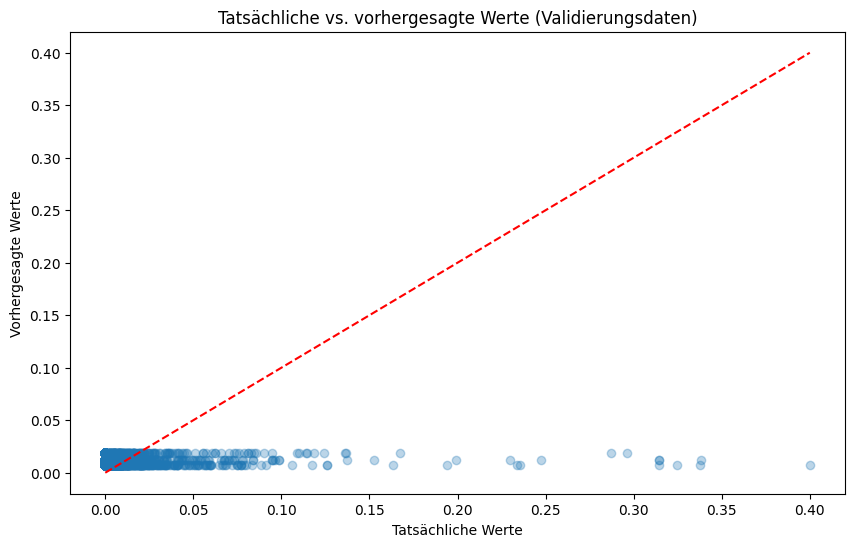

In [17]:
# Ergebnisplots: Tatsächliche vs. vorhergesagte Werte

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.xlabel("Tatsächliche Werte")
plt.ylabel("Vorhergesagte Werte")
plt.title("Tatsächliche vs. vorhergesagte Werte (Validierungsdaten)")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--r')

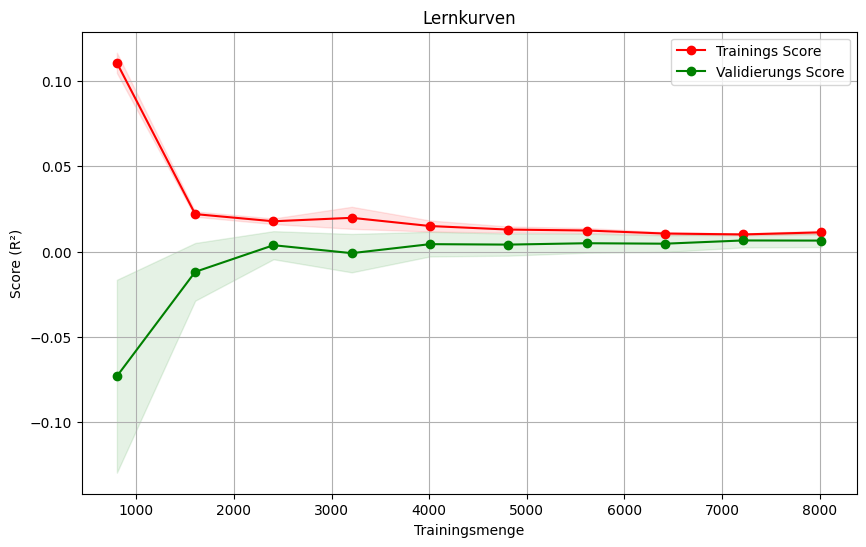

In [21]:
# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Trainings Score')
plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validierungs Score')

plt.xlabel('Trainingsmenge')
plt.ylabel('Score (R²)')
plt.title('Lernkurven')
plt.legend(loc='best')
plt.grid()